In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import data
from hyperparameters import SimArgs
from parameters import weight_generation_r1
from utils import train, inference, prediction_jv_r1
import utils 
import os 
# check gpu with jax
print(jax.devices())
first_exec = True

[CpuDevice(id=0)]


I0000 00:00:1715263114.664127       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
import sys
print(sys.executable)  # Shows the path to the Python interpreter
print(sys.version)     # Shows the Python version

/Users/tristantorchet/Desktop/SNN/SNN_venv/bin/python3
3.10.2 (main, Sep 28 2023, 20:12:42) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [4]:
save_cm = True
save_vmem = True
save_raster = True
save_results = True
save_w = False

alpha_enable = False
output_reset = True
bias_enable = True
args = SimArgs(
    n_in=700,
    n_h=256,
    bias_enable=bias_enable,
    train_tau=False,
    seed=42,
    tau_mem=20e-3,
    tau_syn=10e-3,
    nb_epochs=13,
    lr=0.001,
)
args.pos_w = False

In [5]:
train_loader, val_loader, test_loader = data.get_data_loaders(args)
in_spikes_test_batch0, gt_labels_test_batch0 = next(iter(test_loader))
print(f'{in_spikes_test_batch0.shape=}, {gt_labels_test_batch0.shape=}')
print(f'We will vmap on the first dimension, so each thread will process one sample of size {in_spikes_test_batch0.shape[1:]}')
print(f'We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size {in_spikes_test_batch0.shape[2]}')

datasets:
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_train.h5
 - available at: /Users/tristantorchet/Desktop/SNN/audiospikes_700/shd_test.h5
in_spikes_test_batch0.shape=(64, 150, 700), gt_labels_test_batch0.shape=(64,)
We will vmap on the first dimension, so each thread will process one sample of size (150, 700)
We will scan on the first dimension of the sample, so at every timestep we will process a 1-D array of size 700


In [6]:
@jax.custom_jvp
def gr_than(x, thr):
    """ Thresholding function for spiking neurons. """
    return (x > thr).astype(jnp.float32)


@gr_than.defjvp
def gr_jvp(primals, tangents):
    """ Surrogate gradient function for thresholding. """
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot / (10 * jnp.absolute(x - thr) + 1)**2
    return primal_out, tangent_out


def lif_recurrent(state, input_spikes):
    ''' Vectorized Recurrent Leaky Integrate and Fire (LIF) neuron model
    '''
    global bias_enable
    global alpha_enable
    global output_reset
    
    print(f'{bias_enable=}, {alpha_enable=}, {output_reset=}')

    tau_mem, v_th, beta, alpha = state[1]
    if bias_enable:
        ((Win, Wrec, Wout, Wb), (i_h, v_h, z_h), (i, v, z)) = state[0]
    else: 
        ((Win, Wrec, Wout), (i_h, v_h, z_h), (i, v, z)) = state[0]

    i_h = jnp.dot(Win, input_spikes) + jnp.dot(Wrec, z_h) 

    if alpha_enable:
        i_h = i_h +  alpha * i_h 

    if bias_enable:
        i_h = i_h + Wb

    v_h = beta * v_h + i_h - z_h * v_th
    v_h = jnp.maximum(0, v_h)
    z_h = gr_than(v_h, v_th)

    i = jnp.dot(Wout, z_h) + alpha * i
    v = beta * v + i
    if output_reset: 
        v = v - z * v_th
    v = jnp.maximum(0, v)
    z = gr_than(v, v_th)

    if bias_enable:
        return (([Win, Wrec, Wout, Wb], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)
    else: 
        return (([Win, Wrec, Wout], (i_h, v_h, z_h), (i, v, z)), state[1]), (z_h, v, z)

utils.lif_recurrent = lif_recurrent        

In [7]:
key = jax.random.PRNGKey(args.seed)
key, w = weight_generation_r1(key, args, bias_enable=args.bias_enable)
log_params = f'{w[0].shape=} (in), {w[1].shape=} (rec), {w[2].shape=} (out)'
if args.bias_enable: 
    log_params += f', {w[-1].shape=} (bias)' 
beta = float(jnp.exp(-args.timestep/args.tau_mem))
alpha = float(jnp.exp(-args.timestep/args.tau_syn))
hp = (args.tau_mem, args.v_thr, beta, alpha)
print(f'{len(hp)=}')
print(log_params)
print(f'{len(w)=}')

len(hp)=4
w[0].shape=(256, 700) (in), w[1].shape=(256, 256) (rec), w[2].shape=(20, 256) (out), w[-1].shape=(256,) (bias)
len(w)=4


In [8]:
w_init = w

In [9]:
loaders = (train_loader, val_loader, test_loader)
first_exec = True 
if first_exec:
    get_params, opt_state, hist = train(w, hp, loaders, args)
    w = get_params(opt_state)
    print(f'{len(w)=}')
    first_exec = False
    if save_w: 
        path_weights = f'trained_w/cramer20/r1/{args.n_h}h_'
        if not os.path.exists(path_weights):
            os.makedirs(path_weights)
        if args.pos_w: 
            path_weights += 'posWin_'
        if bias_enable: 
            path_weights += 'bias_'
        if alpha_enable:
            path_weights += 'alpha_'
        if output_reset:
            path_weights += 'outReset_'
        jnp.save(f'{path_weights}/win.npy', w[0])
        jnp.save(f'{path_weights}/wrec.npy', w[1])
        jnp.save(f'{path_weights}/wout.npy', w[2])
        if bias_enable: 
            jnp.save(f'{path_weights}/wb.npy', w[3])

Epoch |Loss      |Acc       |Val Acc   |Test Acc  |Val Loss  |Test Loss 
------|----------|----------|----------|----------|----------|----------
bias_enable=True, alpha_enable=False, output_reset=True
0     |2.4064    |0.2085    |0.3175    |0.3232    |1.9755    |1.8709    
1     |1.8348    |0.3611    |0.3819    |0.4326    |1.7655    |1.6760    
2     |1.6419    |0.4397    |0.4675    |0.4777    |1.5852    |1.5296    
3     |1.4515    |0.5252    |0.5031    |0.4955    |1.4506    |1.4690    
4     |1.2906    |0.5760    |0.5531    |0.5594    |1.2983    |1.3340    
5     |1.1605    |0.6292    |0.5806    |0.5522    |1.2000    |1.3077    
6     |1.0623    |0.6614    |0.6025    |0.5821    |1.1355    |1.2626    
7     |0.9807    |0.6878    |0.6375    |0.5813    |1.0481    |1.2416    
9     |0.8445    |0.7331    |0.6381    |0.5915    |1.0185    |1.1888    
10    |0.7915    |0.7506    |0.6775    |0.6031    |0.9551    |1.1955    
11    |0.7426    |0.7695    |0.6925    |0.5902    |0.8904    |1.1994

In [10]:
train_loss, train_acc, _ = inference(w, hp, train_loader)
val_loss, val_acc, _ = inference(w, hp, val_loader)
test_loss, test_acc, (test_lbls, test_preds) = inference(w, hp, test_loader)
print(f'{test_lbls.shape=}')
print(f'{test_loss.mean()=:.4f}, {test_acc.mean()=:.4f}')
test_loss_init, test_acc_init, (test_lbls_init, test_preds_init) = inference(w_init, hp, test_loader)
print(f'{test_loss_init.mean()=:.4f}, {test_acc_init.mean()=:.4f}')

test_lbls.shape=(2240,)
test_loss.mean()=1.1420, test_acc.mean()=0.6107
test_loss_init.mean()=3.0015, test_acc_init.mean()=0.0469


In [20]:
if save_results:
    # create a result folder if it does not exist
    if not os.path.exists('results'):
        os.makedirs('results')
    # open the result file csv
    if not os.path.exists('results/cramer20_r1.csv'):
        with open('results/cramer20_r1.csv', 'w') as f:
            f.write('val_acc,test_acc,train_acc,val_loss,test_loss,train_loss,'
                    'n_h,nb_epochs,lr,bias_enable,output_reset,alpha_enable,pos_w,tau_mem,tau_syn\n')
    # append the result to the csv file
    with open('results/cramer20_r1.csv', 'a') as f:
        f.write(f'{val_acc.mean():.4f},{test_acc.mean():.4f},{train_acc.mean():.4f},'
                f'{val_loss.mean():.4f},{test_loss.mean():.4f},{train_loss.mean():.4f},'
                f'{args.n_h},{args.nb_epochs},{args.lr},{bias_enable},{output_reset},'
                f'{alpha_enable},{args.pos_w},{args.tau_mem},{args.tau_syn}\n')

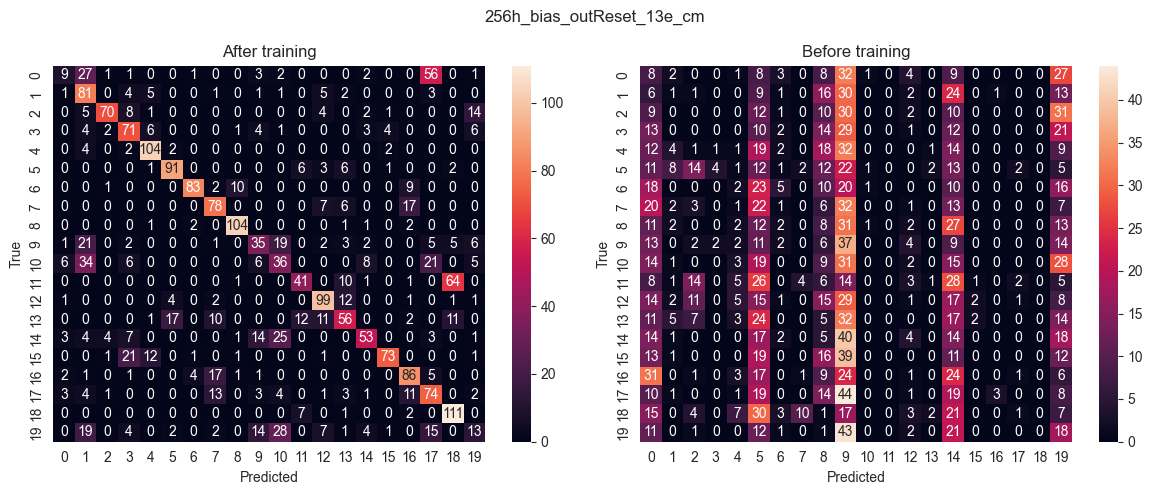

In [21]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_lbls, test_preds)
cm_original = confusion_matrix(test_lbls_init, test_preds_init)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#cm_mask = np.where(cm > 5, 0, 1)
sns.heatmap(cm, annot=True, ax=ax[0], fmt='g')#, mask=cm_mask)
sns.heatmap(cm_original, annot=True, ax=ax[1], fmt='g')
ax[0].set_title('After training')
ax[1].set_title('Before training')
# set x and y labels
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
# save 
path = f'images/cramer20/r1'
image_name = 'cm'
prefix = f'{args.n_h}h_'
if args.pos_w: 
    prefix += 'posWin_'
if bias_enable: 
    prefix += 'bias_'
if alpha_enable: 
    prefix += 'alpha_'
if output_reset: 
    prefix += 'outReset_'
prefix += f'{args.nb_epochs}e_'
image_name = prefix + image_name
plt.suptitle(image_name)
plt.tight_layout()

if save_cm:
    # check if the folder exists
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{image_name}.png', transparent=False, format='png')
    
plt.show()

In [13]:
# use sklearn for the classification report
from sklearn.metrics import classification_report
print(classification_report(test_lbls, test_preds))
# print report sorted by f1-score
report = classification_report(test_lbls, test_preds, output_dict=True)
# report as pandas dataframe
import pandas as pd
report = pd.DataFrame(report).T
#sort report by f1
print(report[:20].sort_values('f1-score', ascending=False))

              precision    recall  f1-score   support

           0       0.35      0.09      0.14       103
           1       0.40      0.78      0.53       104
           2       0.88      0.67      0.76       105
           3       0.56      0.70      0.62       102
           4       0.79      0.91      0.85       114
           5       0.78      0.83      0.81       110
           6       0.91      0.79      0.85       105
           7       0.62      0.72      0.67       108
           8       0.87      0.94      0.90       111
           9       0.43      0.34      0.38       102
          10       0.31      0.30      0.30       122
          11       0.62      0.35      0.45       118
          12       0.71      0.82      0.76       121
          13       0.55      0.47      0.51       120
          14       0.69      0.46      0.55       115
          15       0.89      0.66      0.76       111
          16       0.66      0.73      0.69       118
          17       0.41    

In [14]:
zh_init, v_init, z_init = prediction_jv_r1(w_init, hp, in_spikes_test_batch0)
zh, v, z = prediction_jv_r1(w, hp, in_spikes_test_batch0)

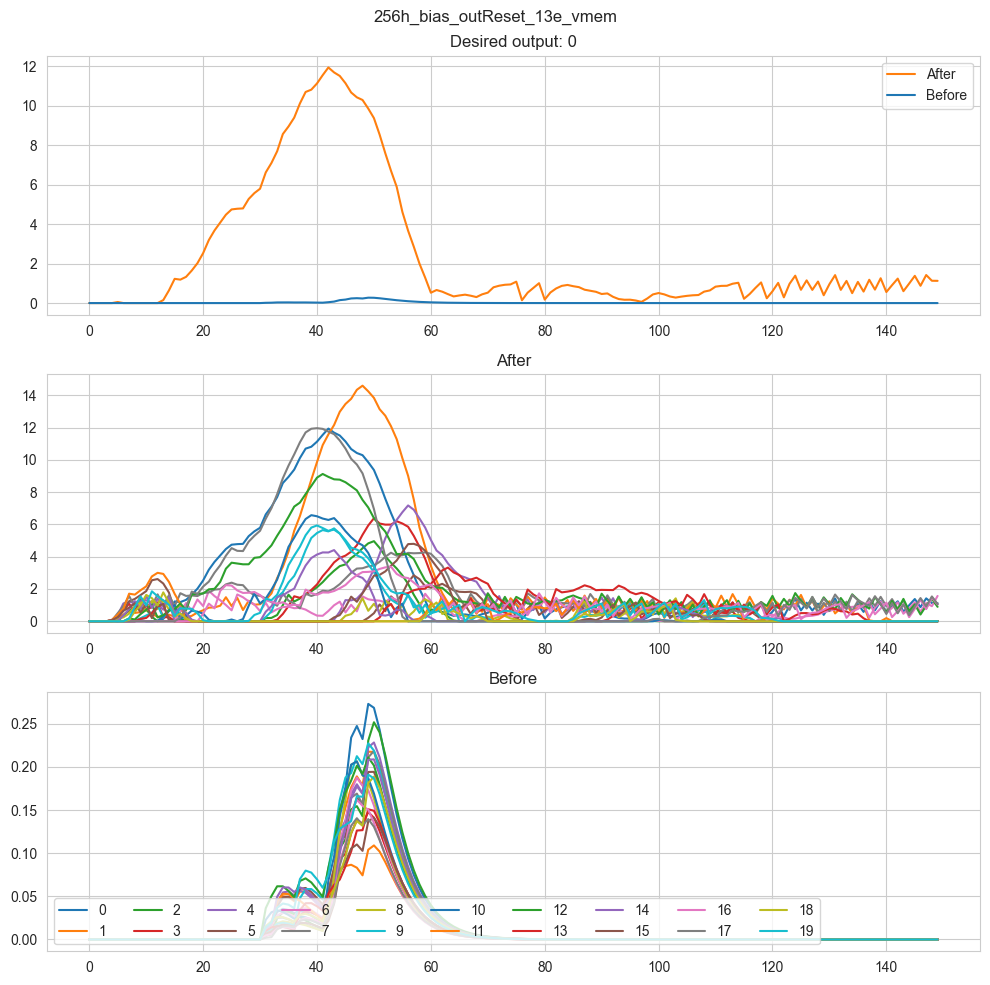

In [22]:
import matplotlib.pyplot as plt

id_sample = 6
v0_init = v_init[id_sample]
v0 = v[id_sample]
# plot the membrane potential of the 20 neurons with 150 timestep 
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
for i in range(20):
    if i == gt_labels_test_batch0[id_sample]:
        ax[0].plot(v0[:, i], label=f'After', color='C1')
        ax[0].plot(v0_init[:, i], label='Before', color='C0')
    ax[1].plot(v0[:, i], label=f'{i}')
    ax[2].plot(v0_init[:, i], label=f'{i}')
titles = [f'Desired output: {gt_labels_test_batch0[id_sample]}', 'After', 'Before']
for i in range(3):
    ax[i].set_title(f'{titles[i]}')
    if i!=1: ax[i].legend()
fig.tight_layout()
plt.legend(ncol=10, loc='lower left')
image_name = 'vmem'
image_name = prefix + image_name
plt.suptitle(f'{image_name}')
plt.tight_layout()

if save_vmem: 
    path = f'images/cramer20/r1'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{image_name}.png', transparent=False, format='png')
plt.show()
        

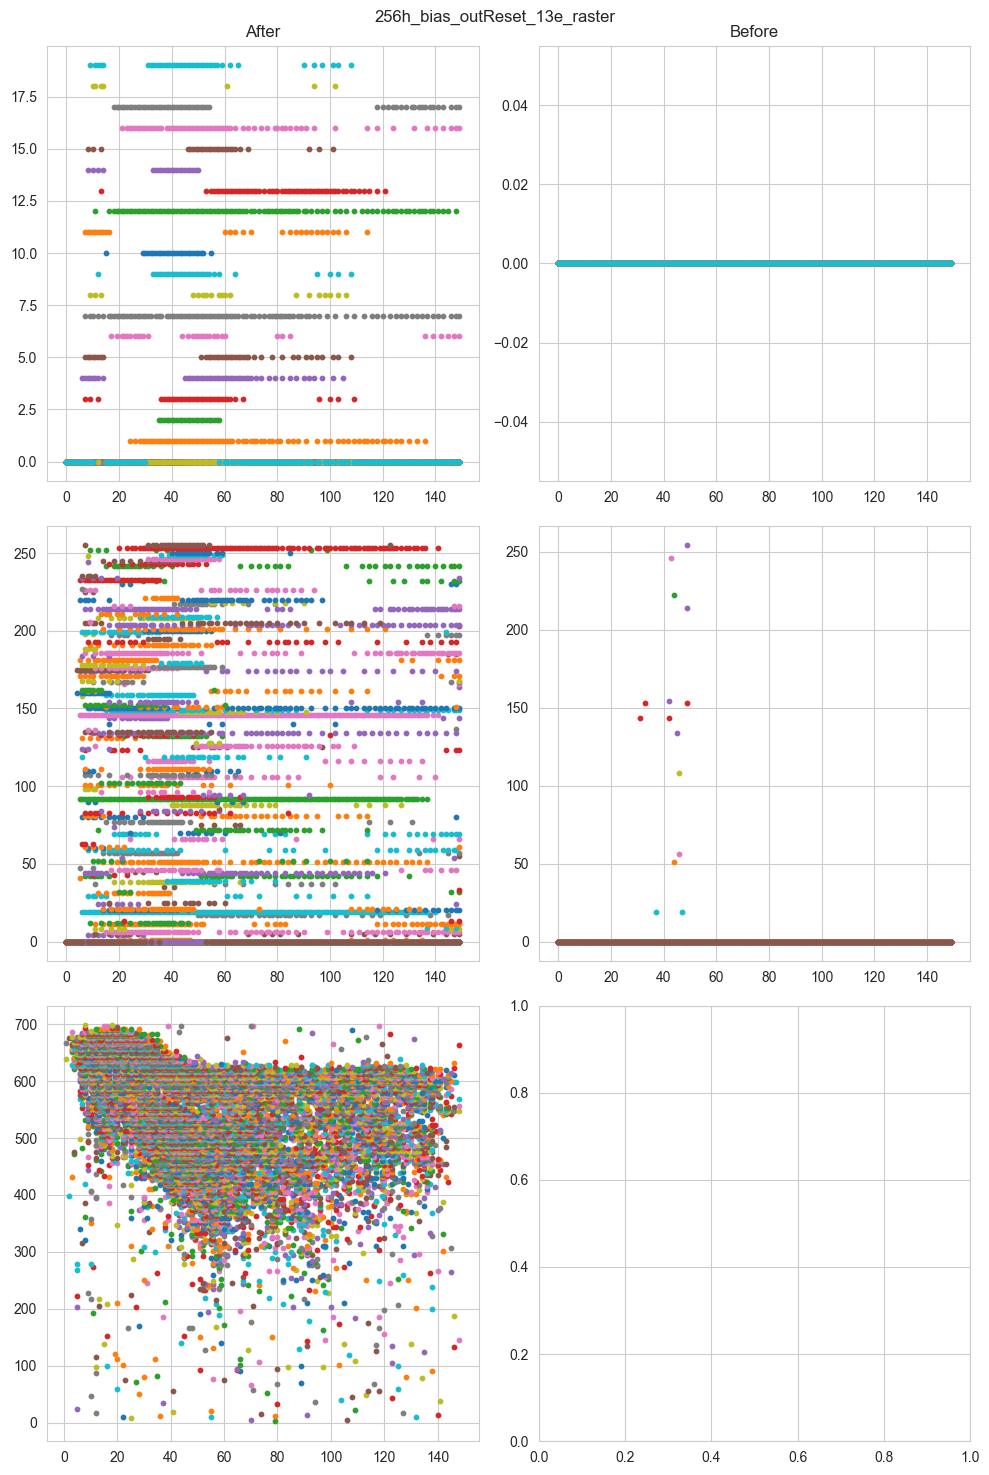

In [23]:
# plot the raster plot of the 20 neurons with 150 timestep
z0 = z[id_sample]
zh0 = zh[id_sample]
z0_init = z_init[id_sample]
zh0_init = zh_init[id_sample]
in_spikes_sample = jnp.where(in_spikes_test_batch0[id_sample] == 0, jnp.nan, 1)
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
t = jnp.arange(150)
for i in range(20):
    ax[0,0].scatter(t, z0[:, i] * i, s=10, label=f'{i}')
    ax[0,1].scatter(t, z0_init[:, i] * i, s=10, label=f'{i}')
for i in range(zh.shape[-1]):
    ax[1,0].scatter(t, zh0[:, i] * i, s=10, label=f'{i}')
    ax[1,1].scatter(t, zh0_init[:, i] * i, s=10, label=f'{i}')
for i in range(in_spikes_sample.shape[-1]):
    ax[2,0].scatter(t, in_spikes_sample[:, i] * i, s=10, label=f'{i}')
image_name = 'raster'
image_name = prefix + image_name
ax[0,0].set_title('After')
ax[0,1].set_title('Before')
plt.suptitle(f'{image_name}')
plt.tight_layout()
if save_raster: 
    path = f'images/cramer20/r1'
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig(f'{path}/{image_name}.png', transparent=False, format='png')
plt.show()

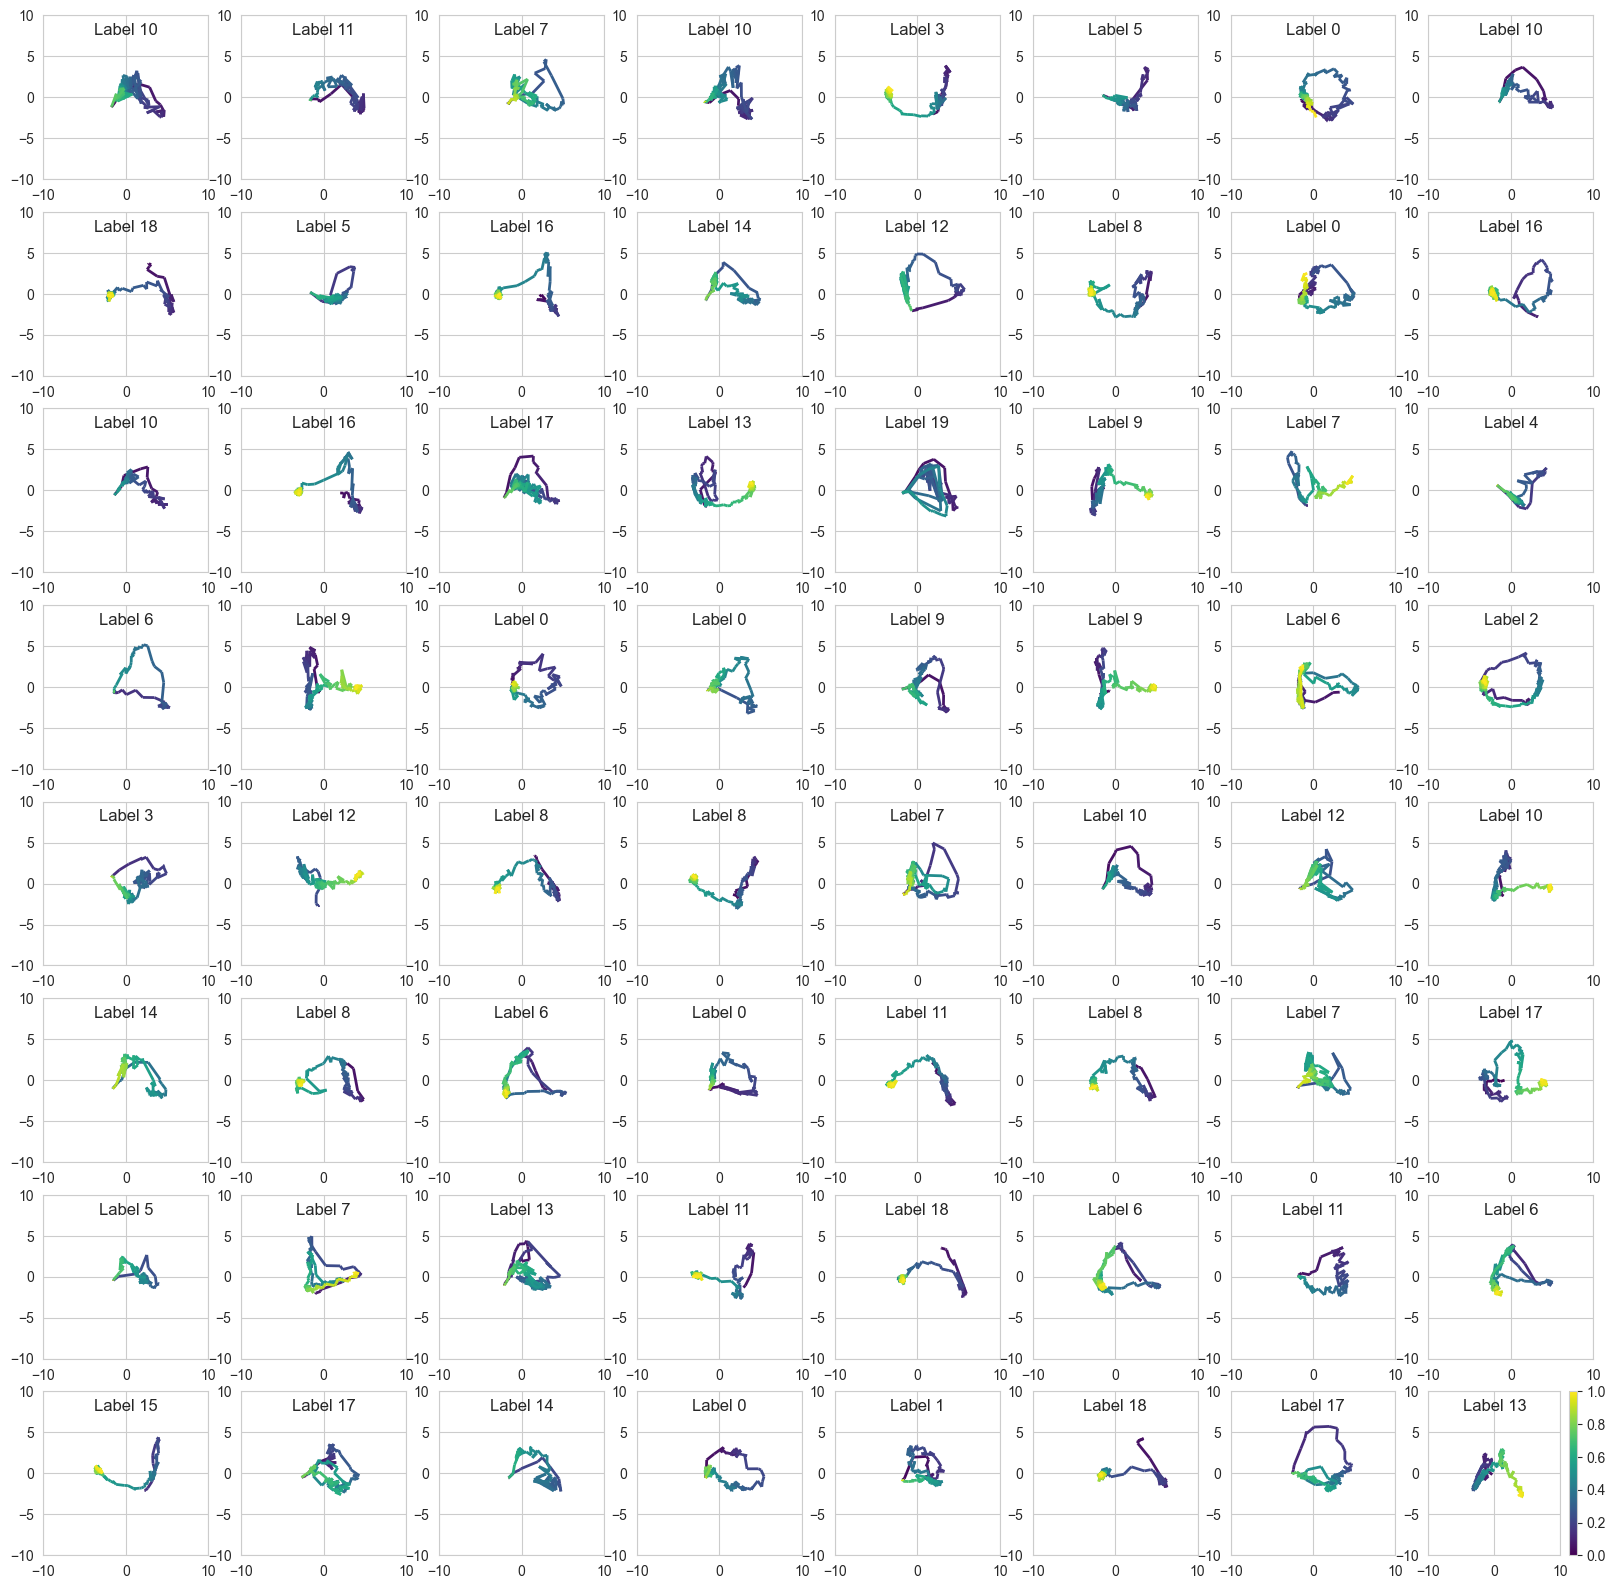

In [64]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

t = np.arange(150)

fig, axs = plt.subplots(8, 8, figsize=(20, 20))
for i in range(64):
    zh0 = zh[i]
    zh0_pca = pca.fit_transform(zh0)
    x    = zh0_pca[:, 0]
    y    = zh0_pca[:, 1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cols = np.linspace(0,1,len(x))
    lc = LineCollection(segments, cmap='viridis')
    lc.set_array(cols)
    lc.set_linewidth(2)
    line = axs[i//8, i%8].add_collection(lc)
    # set x and y limits
    axs[i//8, i%8].set_xlim(-10, 10)
    axs[i//8, i%8].set_ylim(-10, 10)
    # add a title with the label
    axs[i//8, i%8].set_title(f'Label {gt_labels_test_batch0[i]}', y=1, pad=-14)

fig.colorbar(line ,ax=axs[i//8, i%8])

# make the line a gradient of color
# display colorbar
#plt.colorbar()
plt.show()

In [44]:
wrec = w[1]
# compute the rank of wrec
from scipy.linalg import svdvals
print(f'{np.linalg.matrix_rank(wrec)=}')
print(f'{np.linalg.matrix_rank(w_init[1])=}')


np.linalg.matrix_rank(wrec)=256
np.linalg.matrix_rank(wrec_original)=256
